### This notebook describes some steps used to detect CNV regions using SRBreak

In [1]:
%load_ext rpy2.ipython

####Load SRBreak into R

In [2]:
%%R
library("SRBreak")



Loading required package: CNVrd2
Loading required package: VariantAnnotation
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: GenomeInfoDb
Loading required package: stats4
Loading required pa

### Detect CNVs and their breakpoints 

###Example: single-end reads

####Please download *BamSimulatedData* and extract it into the current directory

####If you are using a dockerized version, you can go to the **root** directory and see the "BamSimulatedData" directory


####Prepare parameters


In [8]:
%%R
#Set windows to count reads
windows = 500

dirBamFile = "./BamSimulatedData/"

st = 101100001
en = 102100000
chr = "chr1"
 



#### You only need function *SRBreak* to obtain results

In [9]:
%%R

system.time(outputSRBreak <- SRBreak(readDepthWindow = windows,##read-depth window size
                                     
                                     chr = chr, ##Chromosome name
                                                                                                            
                                     st = st, ##Start position
                                     
                                     en = en, ##End position
                                     
                                     dirBamFile = dirBamFile, ##Bam files' directory
                                     
                                     detectAllRegion = TRUE, ##Set this = TRUE in order to obtain all CNV regions
                                     
                                     rdQualityMapping = 0, ##Mapping quality (used in read-depth method)
                                                             
                                     testType = "Count", ##Test type
                                     
                                     correctGC = TRUE, ##Correct GC content
                                     
                                     upperCNThreshold = 0.25, ##Larger than this threshold is duplication
                                     
                                     lowerCNThreshold = -0.25, ##Smaller than this threshold is deletion
                                     
                                     countThreshold = 1, ##Number of duplications/deletions 
                                     
                                     minLengthSV = 1000, ##Minimum length of a duplication/deletion event

                                    #inputRawReadCountMatrix = readCountMatrix,
                                     usingPairedEnds = FALSE, ##Not use paired-end information,
                                                            
                                     thresholdOfIntersectionBetweenRDandPEM = 0.9 #Not useful if only single-end reads used
                                     
                                    ))

Reading file: Del.1.L1000.101561000.101562000.fa.10.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.11.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.12.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.13.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.14.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.15.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.1.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.2.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.3.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.4.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.5.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.6.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.7.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562000.fa.8.x.bwa.sorted.bam
Reading file: Del.1.L1000.101561000.101562

####SV and their predicted breakpoints are in *outputSRBreak$svResult*

In [22]:
%%R
rawoutputSV <- outputSRBreak$svResult

###Write out
write.table(rawoutputSV, "SVresults.txt", quote = FALSE)

###Next steps are aimed to compare simulated breakpoints and predicted breakpoints

#### We can see all simulated breakpoints by extracting sample names

In [10]:
%%R
sampleNames <- dir("BamSimulatedData", "bam$")

sampleOfSV <- sampleNames[grep("Dup|Del", sampleNames)]
sampleOfSV

listSV <- unique(t(sapply(strsplit(sampleOfSV, ".", fixed = TRUE), function(x) x[4:5])))
    
    
simulatedSV  <- IRanges(as.integer(listSV[, 1]), as.integer(listSV[, 2]))
    
sort(simulatedSV)
    

IRanges of length 6
        start       end width
[1] 101545220 101630000 84781
[2] 101555000 101605000 50001
[3] 101556000 101576000 20001
[4] 101558000 101568000 10001
[5] 101560000 101565000  5001
[6] 101561000 101562000  1001


####Take a look at results from *outputSRBreak*, and then extract predicted breakpoints around simulated breakpoints

In [11]:
%%R

outputSV <- IRanges(as.integer(rawoutputSV[, 2]), as.integer(rawoutputSV[, 3]))

outputSV 

###Check whether the simulated breakpoints are in these results
outputSV[(start(outputSV) > (101545220 - 5000)) & (end(outputSV) < (101630000 + 50000)) ]

IRanges of length 7
        start       end width
[1] 101545221 101630001 84781
[2] 101555000 101605001 50002
[3] 101556001 101576005 20005
[4] 101556005 101576001 19997
[5] 101558001 101568001 10001
[6] 101560001 101565000  5000
[7] 101561001 101562001  1001


### All results of output are in *outputSRBreak*

####Check results of some samples

In [12]:
%%R
###The first row is information including chr, start, end of a structural variant, and then sample names
rawoutputSV[1, ]

                                                           chr 
                                                        "chr1" 
                                                         start 
                                                   "101100001" 
                                                           end 
                                                   "101101841" 
        Del.1.L1000.101561000.101562000.fa.10.x.bwa.sorted.bam 
                                                           "N" 
        Del.1.L1000.101561000.101562000.fa.11.x.bwa.sorted.bam 
                                                           "N" 
        Del.1.L1000.101561000.101562000.fa.12.x.bwa.sorted.bam 
                                                           "N" 
        Del.1.L1000.101561000.101562000.fa.13.x.bwa.sorted.bam 
                                                           "N" 
        Del.1.L1000.101561000.101562000.fa.14.x.bwa.sorted.bam 
                                        

In [13]:
%%R
###Results on a row (a structural event)
rawoutputSV[4,]

                                                           chr 
                                                        "chr1" 
                                                         start 
                                                   "101128963" 
                                                           end 
                                                   "101132312" 
        Del.1.L1000.101561000.101562000.fa.10.x.bwa.sorted.bam 
                                                           "N" 
        Del.1.L1000.101561000.101562000.fa.11.x.bwa.sorted.bam 
                                                           "N" 
        Del.1.L1000.101561000.101562000.fa.12.x.bwa.sorted.bam 
                                                           "N" 
        Del.1.L1000.101561000.101562000.fa.13.x.bwa.sorted.bam 
                                                           "N" 
        Del.1.L1000.101561000.101562000.fa.14.x.bwa.sorted.bam 
                                        

###We can plot read-depth information using the function *plotCNVrd2* in SRBreak package

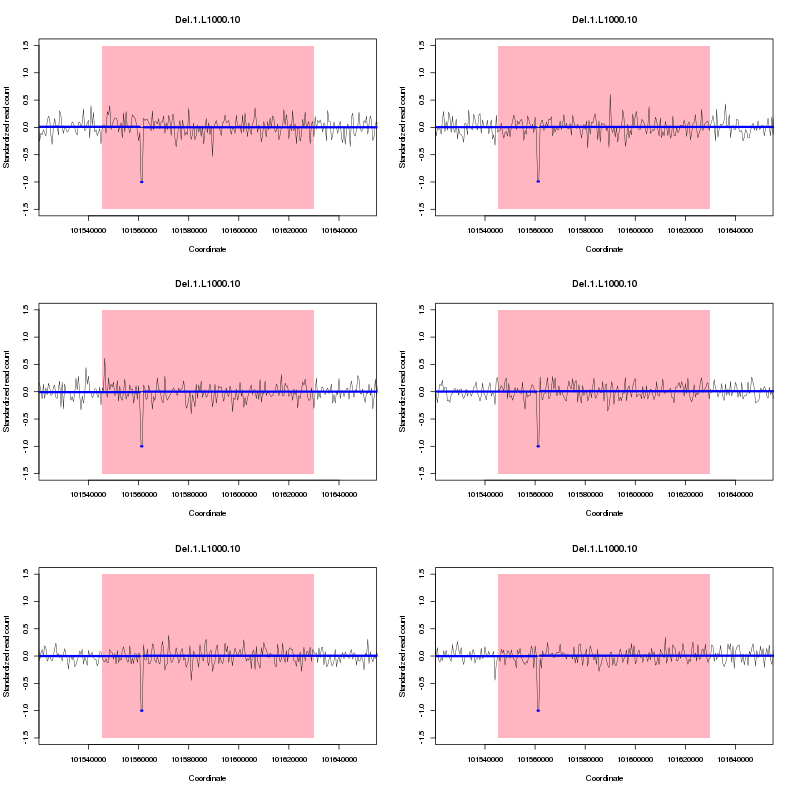

In [21]:
%%R -w 28 -h 28 -u cm

sampleNames 

##Should make a CNVrd2 object because we will use the CNVrd2 package to plot

objectCNVrd2 <- new("CNVrd2", windows = windows,
                    chr = "Chr1", 
                    st = st, en = en,
                    genes = c(101545221, 101630001), ##Can choose any positions if you don't genotype
                    dirBamFile = dirBamFile)

par(mfrow = c(3, 2))
for (ii in 1:6){
        plotCNVrd2(Object = objectCNVrd2,
              segmentObject = outputSRBreak$resultSegment,
              sampleName = sampleNames[ii] ,
              
                   ylim = c(-1.5, 1.5), 
                   
                   xlim = c(101545221 - 20000, 101630001 + 20000),
                   segmentCOLOUR = "blue", ##Set color = flesh color
    main = substr(sampleNames[ii], 1, 14))
    
    
        
          
        
        }